# Pose estimation for Gradient Boost Classifier
Using [this model](https://sigmoidal.ai/en/real-time-human-pose-estimation-using-mediapipe/) to get a pose estimation to then process further for a simpler model.

In [1]:
import random
from pathlib import Path
from typing import Callable

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mediapipe as mp
import cv2

total files: 705
random file chosen C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\forehand\seq_021\F_021_002.jpeg


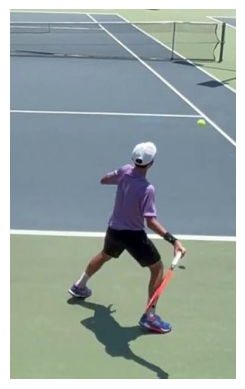

In [45]:
# load random image
DATA_PATH = Path(
    r"C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped")
DATA_PATH_CUSTOM_PICTURES = Path(
    r"C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel"
)

all_file_paths = []
for path in DATA_PATH.glob("**/*"):
    if path.is_file() and path.suffix == ".jpeg":
        all_file_paths.append(path)
        
all_file_paths_custom_pictures = []
for path in DATA_PATH_CUSTOM_PICTURES.glob("**/*"):
    if path.is_file() and path.suffix == ".jpeg":
        all_file_paths.append(path)

print(f"total files: {len(all_file_paths)}")
random_file_path = random.choice(all_file_paths)
print(f"random file chosen {random_file_path}")

random_image = cv2.imread(str(random_file_path))
random_image_width = random_image.shape[1]
random_image_height = random_image.shape[0]

fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(random_image[...,::-1])

# Pose estimation
The idea is, to use a pose estimator to locate important body parts and then use these values to train a much simpler model.

In [13]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [46]:
with mp_pose.Pose(static_image_mode=True) as pose:
    annotated_img = random_image.copy()
    # Processes the image.
    results = pose.process(random_image)
    # Set the circle radius for drawing the 'landmarks'.
    # The radius is scaled as a percentage of the image's height.
    circle_radius = int(.007 * random_image_height)
    # Specifies the drawing style for the 'landmarks'.
    point_spec = mp_drawing.DrawingSpec(color=(220, 100, 0), thickness=-1, circle_radius=circle_radius)
    # Draws the 'landmarks' on the image.
    mp_drawing.draw_landmarks(annotated_img,
                              landmark_list=results.pose_landmarks,
                              landmark_drawing_spec=point_spec)


C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [47]:
# Make a copy of the original image.
annotated_img = random_image.copy()
# Specifies the drawing style for landmark connections.
line_spec = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
# Draws both the landmark points and connections.
mp_drawing.draw_landmarks(
    annotated_img,
    landmark_list=results.pose_landmarks,
    connections=mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=point_spec,
    connection_drawing_spec=line_spec
)

In [48]:
# Select the coordinates of the points of interest.
l_shoulder_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * random_image_width)
l_shoulder_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * random_image_height)
l_elbow_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x * random_image_width)
l_elbow_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y * random_image_height)
l_wrist_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * random_image_width)
l_wrist_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * random_image_height)
l_hip_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x * random_image_width)
l_hip_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y * random_image_height)

r_shoulder_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * random_image_width)
r_shoulder_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * random_image_height)
r_elbow_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x * random_image_width)
r_elbow_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y * random_image_height)
r_wrist_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * random_image_width)
r_wrist_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * random_image_height)
r_hip_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * random_image_width)
r_hip_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * random_image_height)

l_ear_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x * random_image_width)
l_ear_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y * random_image_height)
r_ear_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].x * random_image_width)
r_ear_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].y * random_image_height)


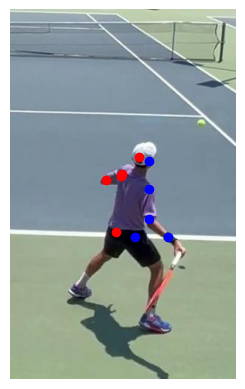

In [49]:
# Displaying a graph with the selected points.
fig2, ax2 = plt.subplots()
ax2.set_axis_off()
ax2.imshow(random_image[:, :, ::-1])
# left side marked red
ax2.plot([l_shoulder_x, l_elbow_x, l_wrist_x, l_hip_x, l_ear_x], [l_shoulder_y, l_elbow_y, l_wrist_y, l_hip_y, l_ear_y], 'ro')
# right side marked blue
ax2.plot([r_shoulder_x, r_elbow_x, r_wrist_x, r_hip_x, r_ear_x], [r_shoulder_y, r_elbow_y, r_wrist_y, r_hip_y, r_ear_y], 'bo')
plt.show()

As you can see, this works pretty well.

TODO: Show more samples!

**CAUTION:**
A very important thing at this point would also be to properly evaluate the pose estimation model. Due to the limited time for this project, we simply suppose the pose estimation model to perform good enough for our task.

# Define Features
We define the shoulder, elbow, wrist and ear position on each side relative to the hips middle position (hips left and hips right) normalized to the image size.

X-Axis: A negative value indicates its position is on the **left** of the hip center

Y-Axis: A negative value indicates its position is **below** the hip center


In [57]:
def get_pose_features_of_image(pose_estimator, image_path: Path) -> dict[str, float]:
    image = cv2.imread(str(image_path))
    results = pose_estimator.process(image)
    
    if results.pose_landmarks is None:
        print(f"FAILED FOR IMAGE {image_path}")
        return {"relLeftShoulderX": np.nan,
            "relLeftShoulderY": np.nan,
            "relLeftElbowX": np.nan,
            "relLeftElbowY": np.nan,
            "relLeftWristX": np.nan,
            "relLeftWristY": np.nan,
            "relRightShoulderX": np.nan,
            "relRightShoulderY": np.nan,
            "relRightElbowX": np.nan,
            "relRightElbowY": np.nan,
            "relRightWristX": np.nan,
            "relRightWristY": np.nan}
        
    l_hip_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x
    l_hip_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y
    
    r_hip_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x
    r_hip_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y
    
    center_hip_x = (l_hip_x + r_hip_x) / 2
    center_hip_y = (l_hip_y + r_hip_y) / 2
    
    l_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x
    l_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y 
    l_elbow_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].x
    l_elbow_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ELBOW].y 
    l_wrist_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x
    l_wrist_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y 
    
    r_shoulder_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x
    r_shoulder_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y 
    r_elbow_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].x
    r_elbow_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ELBOW].y 
    r_wrist_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x
    r_wrist_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y 
    
    return {"relLeftShoulderX": l_shoulder_x - center_hip_x,
            "relLeftShoulderY": l_shoulder_y - center_hip_y,
            "relLeftElbowX": l_elbow_x - center_hip_x,
            "relLeftElbowY": l_elbow_y - center_hip_y,
            "relLeftWristX": l_wrist_x - center_hip_x,
            "relLeftWristY": l_wrist_y - center_hip_y,
            "relRightShoulderX": r_shoulder_x - center_hip_x,
            "relRightShoulderY": r_shoulder_y - center_hip_y,
            "relRightElbowX": r_elbow_x - center_hip_x,
            "relRightElbowY": r_elbow_y - center_hip_y,
            "relRightWristX": r_wrist_x - center_hip_x,
            "relRightWristY": r_wrist_y - center_hip_y}
        
    

def get_pose_features(pose_estimator, folder_path: Path, initial_dataframe: pd.DataFrame | None = None, image_pattern: str = "*.jpeg"):
    label = folder_path.name
    features = []
    for sequence_folder in folder_path.iterdir():
        if not sequence_folder.is_dir():
            continue
        sequence_identifier = int(sequence_folder.name.split("_")[1])
        for image_path in sequence_folder.glob(image_pattern):
            index_in_sequence = int(image_path.stem.split("_")[2])
            
            image_features = get_pose_features_of_image(pose_estimator, image_path)
            image_features.update({"sequenceIdentifier": sequence_identifier,
                             "indexInSequence": index_in_sequence,
                             "label": label})
            
            features.append(image_features)
            
    new_pose_features = pd.DataFrame(features)
    if initial_dataframe is not None:
        return pd.concat([initial_dataframe, new_pose_features]).reset_index(drop=True)
    
    return new_pose_features
            
with mp_pose.Pose(static_image_mode=True) as pose_estimator:        
    pose_features = get_pose_features(pose_estimator, DATA_PATH.joinpath("backhand")) 
    pose_features = get_pose_features(pose_estimator, DATA_PATH.joinpath("forehand"), initial_dataframe=pose_features)     
    pose_features = get_pose_features(pose_estimator, DATA_PATH.joinpath("serve"), initial_dataframe=pose_features)

pose_features.sample(10)

C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_020\B_020_004.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_044\B_044_000.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_048\B_048_003.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\forehand\seq_014\F_014_003.jpeg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_cla

,relLeftShoulderX,relLeftShoulderY,relLeftElbowX,relLeftElbowY,relLeftWristX,relLeftWristY,relRightShoulderX,relRightShoulderY,relRightElbowX,relRightElbowY,relRightWristX,relRightWristY,sequenceIdentifier,indexInSequence,label
382,0.117225,-0.148559,0.177165,-0.139680,0.303530,-0.156322,0.095066,-0.116644,0.018650,-0.045781,0.055948,0.014094,15,2,forehand
666,-0.204532,-0.098201,-0.333546,-0.064930,-0.371051,-0.139830,-0.101003,-0.166566,-0.160912,-0.238029,-0.259024,-0.291790,24,1,serve
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,3,serve
419,-0.002969,-0.231345,-0.182888,-0.182982,-0.097532,-0.204956,0.231013,-0.193400,0.138731,-0.152325,-0.003397,-0.199602,22,4,forehand
395,0.047388,-0.098789,0.025649,-0.056984,0.068034,-0.034920,0.101411,-0.074651,0.127064,-0.026315,0.215996,-0.034936,18,0,forehand
488,-0.092429,-0.118078,-0.146842,-0.082671,-0.130465,-0.117027,0.048624,-0.130338,0.165551,-0.113846,0.281303,-0.122461,36,3,forehand
58,-0.099163,-0.273779,-0.189056,-0.252813,-0.110096,-0.315633,0.207397,-0.269388,0.174926,-0.250734,0.140227,-0.289189,11,3,backhand
607,-0.012245,-0.143429,0.031172,-0.075487,0.052167,-0.030002,-0.112587,-0.125808,-0.187847,-0.057374,-0.289873,-0.099968,12,2,serve
657,-0.042602,-0.165682,-0.025131,-0.219883,-0.078553,-0.273764,-0.105345,-0.132623,-0.212040,-0.095223,-0.297521,-0.145440,22,2,serve
55,-0.125024,-0.152046,-0.169026,-0.070232,-0.273205,-0.022082,-0.032876,-0.159838,-0.109502,-0.082960,-0.221870,-0.046426,11,0,backhand


In [66]:
pose_features.to_pickle("pose_features.pkl")

In [58]:
with mp_pose.Pose(static_image_mode=True) as pose_estimator:        
    pose_features_custom_pictures = get_pose_features(pose_estimator, DATA_PATH_CUSTOM_PICTURES.joinpath("backhand"), image_pattern="*.jpg") 
    pose_features_custom_pictures = get_pose_features(pose_estimator, DATA_PATH_CUSTOM_PICTURES.joinpath("forehand"), initial_dataframe=pose_features_custom_pictures, image_pattern="*.jpg")     
    pose_features_custom_pictures = get_pose_features(pose_estimator, DATA_PATH_CUSTOM_PICTURES.joinpath("serve"), initial_dataframe=pose_features_custom_pictures, image_pattern="*.jpg")

pose_features_custom_pictures.sample(10)

C:\Git\fhnw-mas-data-science\computer-vision-project-tennis\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_000\S_000_003.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_005\S_005_002.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_007\S_007_002.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_taken_Gabriel\serve\seq_020\S_020_002.jpg
FAILED FOR IMAGE C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Te

,relLeftShoulderX,relLeftShoulderY,relLeftElbowX,relLeftElbowY,relLeftWristX,relLeftWristY,relRightShoulderX,relRightShoulderY,relRightElbowX,relRightElbowY,relRightWristX,relRightWristY,sequenceIdentifier,indexInSequence,label
229,-0.085652,-0.107535,-0.110550,-0.051018,-0.122702,-0.035963,0.041138,-0.122955,0.119997,-0.116283,0.162608,-0.152612,45,4,backhand
440,-0.042662,-0.116852,-0.028258,-0.152321,-0.007345,-0.194658,-0.079671,-0.093871,-0.057198,-0.050389,0.026352,-0.027679,10,0,serve
205,-0.001979,-0.100231,0.003432,-0.058087,-0.075371,-0.055667,-0.037457,-0.094150,-0.068360,-0.054318,-0.112403,-0.030690,41,0,backhand
52,-0.029273,-0.094982,-0.046295,-0.053339,-0.108536,-0.046962,-0.011367,-0.094395,-0.039070,-0.059032,-0.109418,-0.048707,10,2,backhand
397,-0.060085,-0.116299,-0.041072,-0.160056,-0.020491,-0.199094,-0.082534,-0.097553,-0.087149,-0.102149,-0.075181,-0.153465,1,2,serve
592,-0.028575,-0.124816,0.007458,-0.166546,0.029138,-0.214855,-0.131789,-0.091695,-0.205379,-0.083926,-0.221189,-0.131941,40,2,serve
378,-0.031518,-0.097113,-0.077910,-0.063633,-0.097175,-0.025771,0.053847,-0.079086,0.023298,-0.046199,-0.044971,-0.041454,24,3,forehand
194,-0.057700,-0.100782,-0.052384,-0.045433,-0.081493,-0.000478,0.035521,-0.112492,0.099084,-0.122525,0.130879,-0.147473,38,4,backhand
127,-0.007182,-0.109068,0.009511,-0.051335,-0.073408,-0.017699,0.006488,-0.114391,-0.010513,-0.059063,-0.082329,-0.019978,25,2,backhand
77,-0.103576,-0.118184,-0.049150,-0.052992,-0.074091,0.000112,-0.040303,-0.131156,0.005320,-0.062551,-0.025203,-0.021181,15,2,backhand


In [59]:
pose_features_custom_pictures.to_pickle("pose_features_custom_pictures.pkl")

# Modelling

In [2]:
pose_features = pd.read_pickle("pose_features.pkl")

# map class labels to numbers
class_mapping = {"forehand": 1,
                 "backhand": 2,
                 "serve": 3}

pose_features_processed = pose_features.copy()
pose_features_processed["label"] = pose_features["label"].map(class_mapping)
pose_features_processed = pose_features_processed.dropna()
pose_features_processed = pose_features_processed.drop("sequenceIdentifier", axis=1)

pose_features_processed.sample(10)

,relLeftShoulderX,relLeftShoulderY,relLeftElbowX,relLeftElbowY,relLeftWristX,relLeftWristY,relRightShoulderX,relRightShoulderY,relRightElbowX,relRightElbowY,relRightWristX,relRightWristY,indexInSequence,label
433,-0.040596,-0.225156,-0.026832,-0.250671,0.030365,-0.314668,0.042915,-0.182538,0.171945,-0.107079,0.318015,-0.079061,3,1
321,0.094254,-0.107980,0.161661,-0.088348,0.242550,-0.086140,0.138875,-0.107111,0.234489,-0.079227,0.327204,-0.089336,1,1
469,-0.197650,-0.229027,-0.284675,-0.133795,-0.251083,-0.161745,0.061695,-0.254579,-0.028616,-0.163581,-0.172097,-0.185868,4,1
6,0.038382,-0.157458,0.107252,-0.080079,0.029834,-0.016264,-0.108548,-0.152831,-0.074932,-0.083644,-0.054003,-0.013514,1,2
91,-0.181028,-0.209574,-0.196607,-0.080305,-0.308507,0.010846,-0.032295,-0.227396,-0.075437,-0.095120,-0.174930,-0.009665,1,2
245,-0.075758,-0.120307,-0.102133,-0.065617,-0.068042,-0.066224,0.069996,-0.114688,0.056989,-0.058428,0.001671,-0.049138,0,2
226,-0.121584,-0.209117,-0.181773,-0.111860,-0.325495,-0.084310,-0.074468,-0.204805,-0.116327,-0.110251,-0.282457,-0.082167,1,2
177,-0.092756,-0.111685,-0.145866,-0.057294,-0.236944,-0.024731,-0.013376,-0.113147,-0.070930,-0.063979,-0.161590,-0.031532,2,2
516,0.070121,-0.120753,0.201922,-0.117175,0.312260,-0.132595,0.087699,-0.120852,0.027484,-0.090598,0.007039,-0.076523,1,1
201,-0.118677,-0.239832,-0.172213,-0.107099,-0.290076,-0.019680,0.019581,-0.247614,-0.090308,-0.122564,-0.205496,-0.034632,1,2


In [3]:
X_train, X_test, y_train, y_test = train_test_split(pose_features_processed.loc[:, pose_features_processed.columns != "label"], pose_features_processed["label"], stratify=pose_features_processed["label"], test_size=0.2, random_state=3)

print(f"Training size: {X_train.shape}")
print(f"Testing size: {X_test.shape}")

Training size: (554, 13)
Testing size: (139, 13)


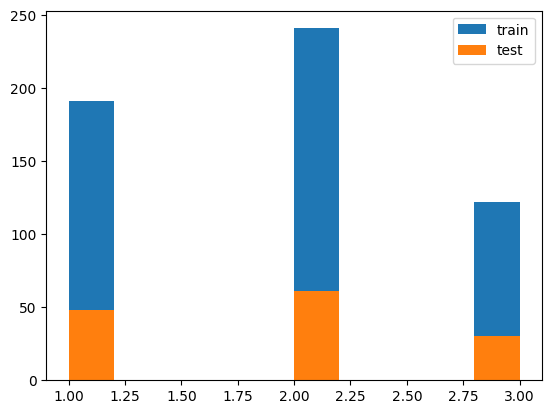

In [4]:
fig, ax = plt.subplots()
ax.hist(y_train, label="train")
ax.hist(y_test, label="test")
ax.legend()

# Model: Gradient Boost Classifier

In [63]:
params = {
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.01,
    "verbose": 1,
    "subsample": 0.8
}

gbc_model = GradientBoostingClassifier(**params)
gbc_model

GradientBoostingClassifier(learning_rate=0.01, subsample=0.8, verbose=1)

In [64]:
gbc_model.fit(X_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.0466           0.0127            1.82s
         2           1.0274          -0.0053            1.24s
         3           1.0194           0.0377            1.08s
         4           1.0045           0.0106            0.97s
         5           0.9883           0.0023            0.90s
         6           0.9715          -0.0014            0.85s
         7           0.9705           0.0586            0.82s
         8           0.9563           0.0053            0.78s
         9           0.9454           0.0179            0.73s
        10           0.9343           0.0157            0.70s
        20           0.8205           0.0195            0.60s
        30           0.7316          -0.0290            0.45s
        40           0.6700           0.0292            0.41s
        50           0.5999           0.0199            0.32s
        60           0.5325          -0.0325            0.27s
       

GradientBoostingClassifier(learning_rate=0.01, subsample=0.8, verbose=1)

In [65]:
gbc_model.score(X_test, y_test)

0.9064748201438849

In [66]:
loss_values = gbc_model.oob_scores_

array([1.05707426, 1.06234753, 1.02462364, 1.01399361, 1.01170297,
       1.01308958, 0.95449323, 0.94919665, 0.93126652, 0.91558514,
       0.91333543, 0.90124856, 0.90823971, 0.85149582, 0.83421427,
       0.87907159, 0.86725414, 0.83077688, 0.85043704, 0.83098492,
       0.79017628, 0.81205819, 0.80575234, 0.81896612, 0.78994716,
       0.76424626, 0.73844571, 0.74009551, 0.71078588, 0.73974813,
       0.74043467, 0.7119948 , 0.70846813, 0.71498891, 0.69555939,
       0.66109726, 0.67299763, 0.68390858, 0.64071539, 0.61149009,
       0.6398729 , 0.64483029, 0.66396191, 0.62534158, 0.62347085,
       0.61393145, 0.60369559, 0.59737151, 0.58724941, 0.56731376,
       0.60540057, 0.58635372, 0.59216702, 0.55207313, 0.5561362 ,
       0.58216113, 0.55033664, 0.56708015, 0.5332705 , 0.56578131,
       0.53950777, 0.50399555, 0.55522462, 0.49944727, 0.51358249,
       0.51297219, 0.50380549, 0.48533276, 0.50289791, 0.43938051,
       0.4810253 , 0.50404684, 0.49706094, 0.48999612, 0.45980

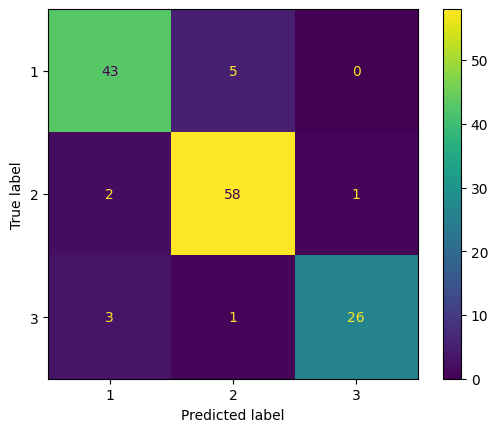

In [8]:
ConfusionMatrixDisplay.from_estimator(gbc_model, X_test, y_test)

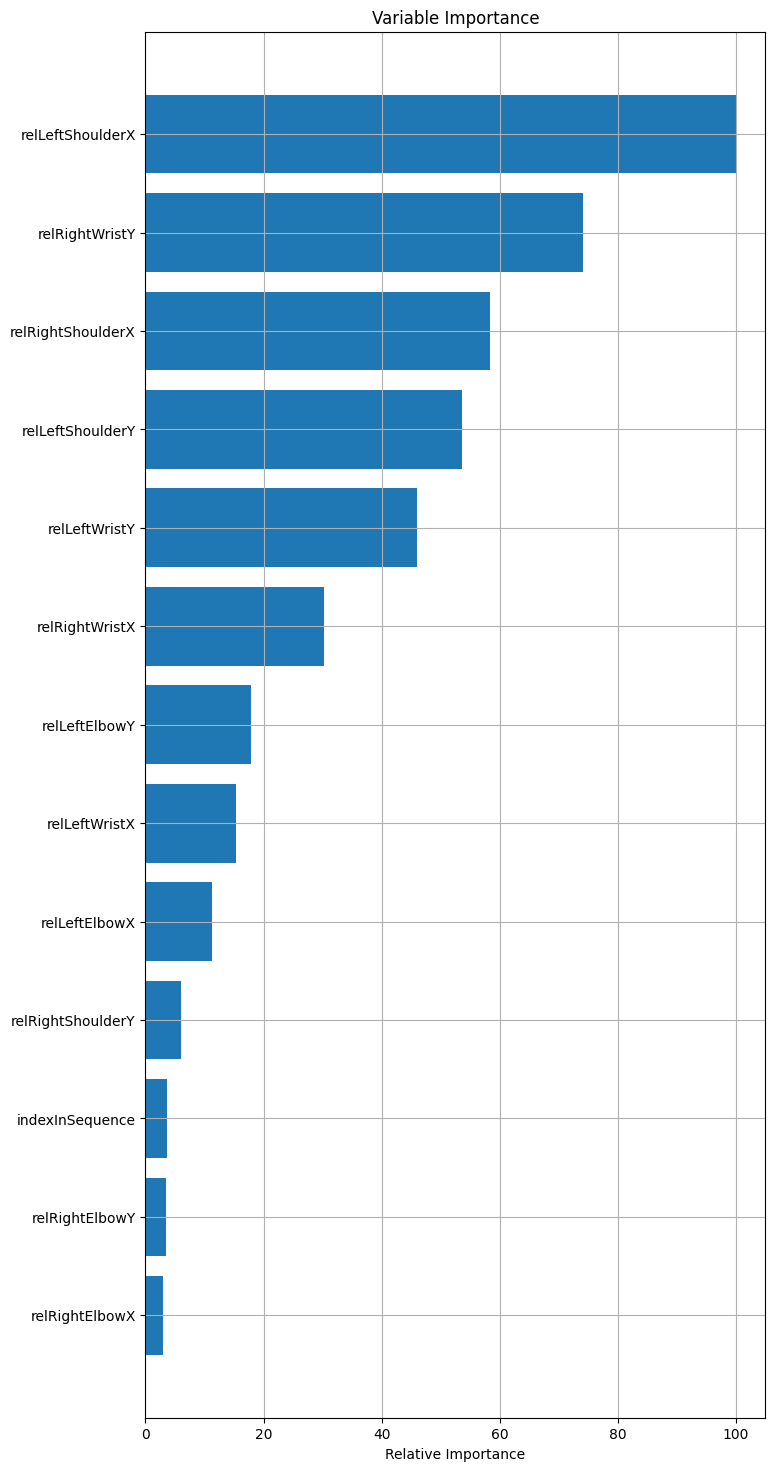

In [27]:
feature_importance = gbc_model.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid(True)
plt.show()

## Testing on custom Pictures

In [60]:
pose_features_custom_pictures = pd.read_pickle("pose_features_custom_pictures.pkl")

# map class labels to numbers
class_mapping = {"forehand": 1,
                 "backhand": 2,
                 "serve": 3}

pose_features_custom_pictures_processed = pose_features_custom_pictures.copy()
pose_features_custom_pictures_processed["label"] = pose_features_custom_pictures["label"].map(class_mapping)
pose_features_custom_pictures_processed = pose_features_custom_pictures_processed.dropna()
pose_features_custom_pictures_processed = pose_features_custom_pictures_processed.drop("sequenceIdentifier", axis=1)

pose_features_custom_pictures_processed.sample(10)

,relLeftShoulderX,relLeftShoulderY,relLeftElbowX,relLeftElbowY,relLeftWristX,relLeftWristY,relRightShoulderX,relRightShoulderY,relRightElbowX,relRightElbowY,relRightWristX,relRightWristY,indexInSequence,label
375,-0.063154,-0.108458,-0.103766,-0.052953,-0.066660,-0.020720,0.070247,-0.104149,0.114235,-0.053632,0.164307,-0.034908,0,1
86,0.004815,-0.122426,0.012903,-0.082394,-0.061468,-0.090502,-0.001070,-0.116708,-0.070059,-0.081200,-0.130665,-0.077328,1,2
566,-0.041650,-0.121164,0.005039,-0.157112,0.027467,-0.196573,-0.142352,-0.087447,-0.229495,-0.080304,-0.245776,-0.125113,1,3
145,-0.036921,-0.111417,-0.080438,-0.061470,-0.137412,-0.051878,0.024980,-0.098995,-0.032720,-0.053898,-0.102471,-0.040129,0,2
462,-0.149276,-0.055810,-0.125682,-0.027757,-0.107526,-0.048680,-0.076648,-0.111164,-0.054728,-0.141871,-0.080351,-0.194846,2,3
138,0.007634,0.098905,0.025146,0.125049,-0.013552,0.164767,-0.028291,0.096971,-0.038726,0.121954,-0.032950,0.155713,3,2
285,-0.054056,-0.145679,0.017548,-0.071697,0.085404,-0.053734,0.063417,-0.150456,0.123772,-0.099154,0.244430,-0.096703,0,1
167,-0.046337,-0.102732,0.003027,-0.056974,-0.039874,-0.012032,-0.061385,-0.100171,-0.064650,-0.052427,-0.129440,-0.030257,2,2
170,-0.071185,-0.123632,-0.099049,-0.064425,-0.141352,-0.049521,0.017758,-0.115942,-0.018742,-0.056087,-0.090166,-0.028884,0,2
317,0.001216,-0.144319,-0.024936,-0.106120,0.024316,-0.118839,0.151619,-0.110328,0.173443,-0.049450,0.139506,-0.077374,2,1


In [61]:
X_custom_pictures = pose_features_custom_pictures_processed.loc[:, pose_features_custom_pictures_processed.columns != "label"]
y_custom_pictures = pose_features_custom_pictures_processed["label"]

gbc_model.score(X_custom_pictures, y_custom_pictures)

0.7370184254606366

[Text(0, 0, 'forehand'), Text(0, 1, 'backhand'), Text(0, 2, 'serve')]

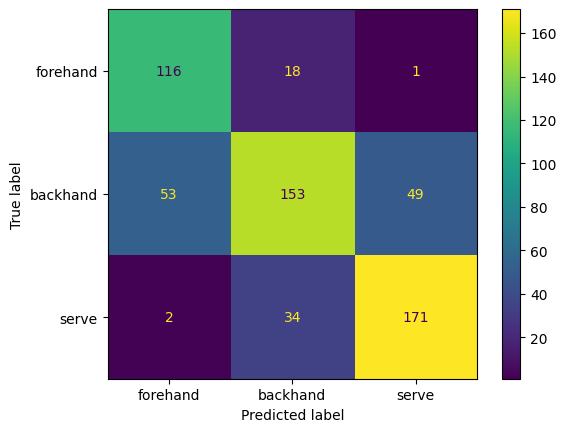

In [62]:
conf_matrix_plot = ConfusionMatrixDisplay.from_estimator(gbc_model, X_custom_pictures, y_custom_pictures)
conf_matrix_plot.ax_.set_xticklabels(class_mapping.keys())
conf_matrix_plot.ax_.set_yticklabels(class_mapping.keys())

# Overfit
- Build Larger Gradient Boost Model
- Train
# Regularize
- Use Gabriels data also for training
- Data augmentation (horizontal flip -> mirror, slight rotate, adapt resolution, adjust brightness)
# Hyper-Parameter Tuning
- Grid-Search on (learning_rate, n_estimators, max_depth, subsample, etc.)